<a href="https://colab.research.google.com/github/Shaksham18/CarVision/blob/main/Car_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import pandas as pd
from IPython.display import Image
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime

In [133]:
%load_ext tensorboard
IMG_SIZE = 224 
BATCH_SIZE = 32
# setup input shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3] # batch,height,width,colour channel
OUTPUT_SHAPE = 1 
# Set up url from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
NUM_EPOCHS = 100 

def process_image(img_path,img_size=[IMG_SIZE,IMG_SIZE]):
  image = tf.io.read_file(img_path)
  # Turn jpg into numerical tensor with 3 color channel(RGB)
  image = tf.image.decode_jpeg(image,channels=3)
  # covert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)
  # Resize Image (244,244)
  image = tf.image.resize(image,size=img_size) 

  return image 

def get_image_label(image_path,label):
  image = process_image(image_path)
  return image,label

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  # if data is Test Data Set, we wont have labels
  if test_data:
    print("Creating test data batches..............")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #Only filepath no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  # if  data is Valid Data Set, we dont need to shuffle
  elif valid_data:
    print("Creating valid data batches..............")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  # Training Batch
  else:
    print("Creating training data batches..............")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) # labels
    # Shuffle pathname and label
    data = data.shuffle(buffer_size = len(X))  
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

def show_25_images(images,labels):
  plt.figure(figsize=(15,15))
  for i in range(25):
    # subplot 5 rows 
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")

# Create a func to build Keras Model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url = MODEL_URL):
  print("Build Model With: ",model_url)
  model = tf.keras.Sequential([
          hub.KerasLayer(model_url), # Layer1 (input layer)
          tf.keras.layers.Dense(units=output_shape,activation="sigmoid") # Layer2 (output layer)
  ])

  #  Compile The Model
  model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )
  model.build(input_shape)

  return model

def create_tensorboard_callback():
  # create directory tensorboard logs
  log_dir = os.path.join(data_path+"logs",
                        #  Make it so log get tracked Whenever we run an experiment
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

def train_model():
  
  model = create_model()

  tensorboard = create_tensorboard_callback()

  # Fit model to data

  model.fit(x=train_data, 
            epochs=NUM_EPOCHS, 
            validation_data=val_data, 
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  
  return model

def load_model(model_path):
  model = tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
  print("Model Loaded")
  return model

def unbatchify(data):
  images_ = []
  labels_ = []

  # loop through unbatch data
  for image,label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)
  
  return images_,labels_

def plot_pred(pred_probalities,labels,images,n=1):
  pred_prob,true_label,image = pred_probalities[n],labels[n],images[n]
  pred_label = round(pred_prob[0])

  # PLot Image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #  Change the color of the title if pred is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  plt.title(f"{pred_label} {pred_prob[0]*100:2.0f}% {true_label}",color=color)



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [134]:
data_path = "drive/MyDrive/Car Vision/"
label_csv = pd.read_csv(data_path+"2000image.csv")
filenames = [data_path+"20kimages/"+fname for fname in label_csv.id]
labels = label_csv["is_car"].to_numpy()
X = filenames
y = labels

In [135]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data=True)
val_data.element_spec

Creating training data batches..............
Creating valid data batches..............


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [136]:
model = train_model()
save_model(model,suffix="full-dataset-mobilenetb2-Adam")
%time
model = load_model('drive/MyDrive/Car Vision/models/20201230-011535-full-dataset-mobilenetb2-Adam.h5')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs
Model Loaded


In [29]:
predictions = model.predict(val_data,verbose=1)
# X_val,y_val

13/13 [==============================] - 111s 9s/step


In [23]:
model.evaluate(val_data)

13/13 [==============================] - 15s 1s/step - loss: 0.0563 - accuracy: 0.9825


[0.05632839724421501, 0.9825000166893005]

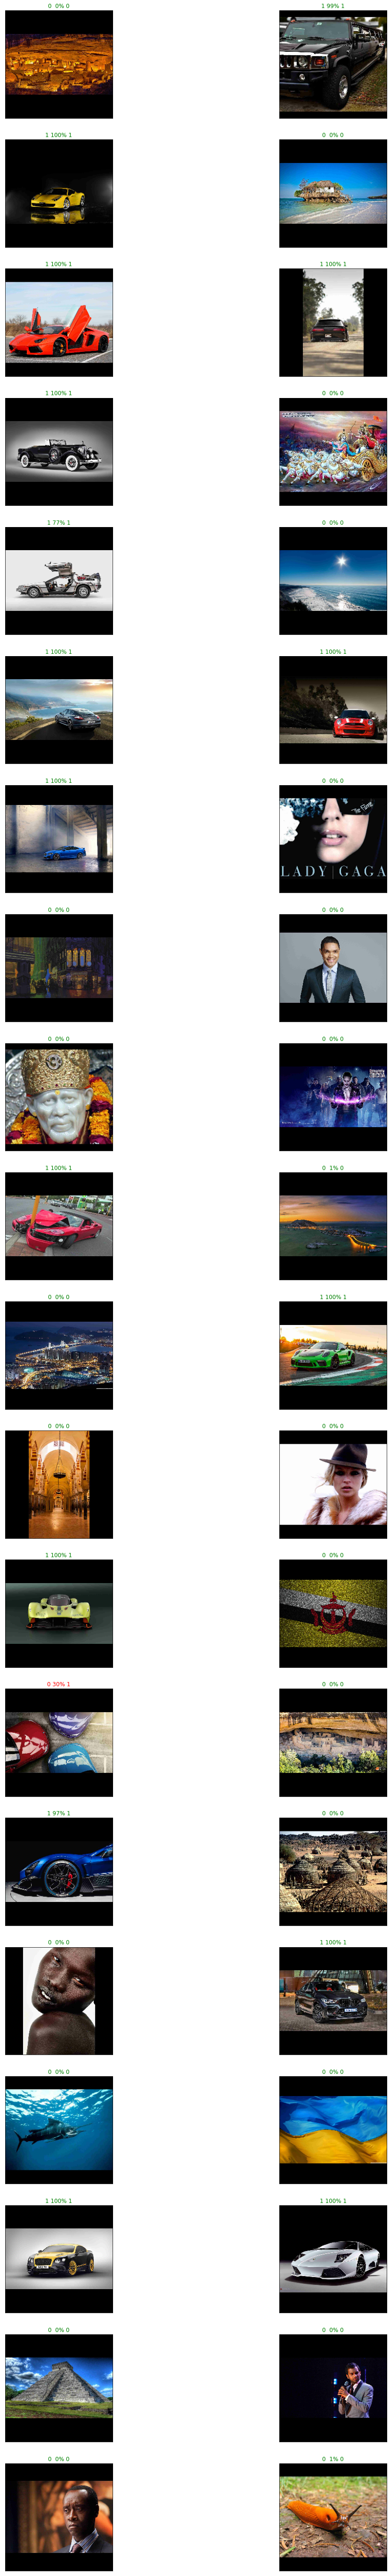

In [30]:
val_images,val_labels = unbatchify(val_data)
i_multiplier = 150
num_rows = 20
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  plot_pred(predictions,val_labels,val_images,n=i+i_multiplier)

plt.show()

In [153]:
image_url = [
            #  "https://cdn.thegentlemansjournal.com/wp-content/uploads/2017/08/4-zandooq-sand-racer-500-gt-4x4-offroad-supercar-664x442-c-center.jpg",
            #  "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/2020-mclaren-570s-mmp-1-1575324044.jpg",
            #  "https://cdn.motor1.com/images/mgl/AeL6N/s1/largest-fast-and-furious-collection.jpg",
            #  "https://specials-images.forbesimg.com/imageserve/5d4726d650409900087ff3d3/960x0.jpg",
            #  "https://resources.mynewsdesk.com/image/upload/ar_16:9,c_fill,dpr_auto,f_auto,g_auto,q_auto,w_336/uszjrxmu9y7q1s2dgsgr.jpg",
             "https://cmsimages.tribuneindia.com/gallary_content/2020/7/2020_7$largeimg_956017842.jpg"
             ]

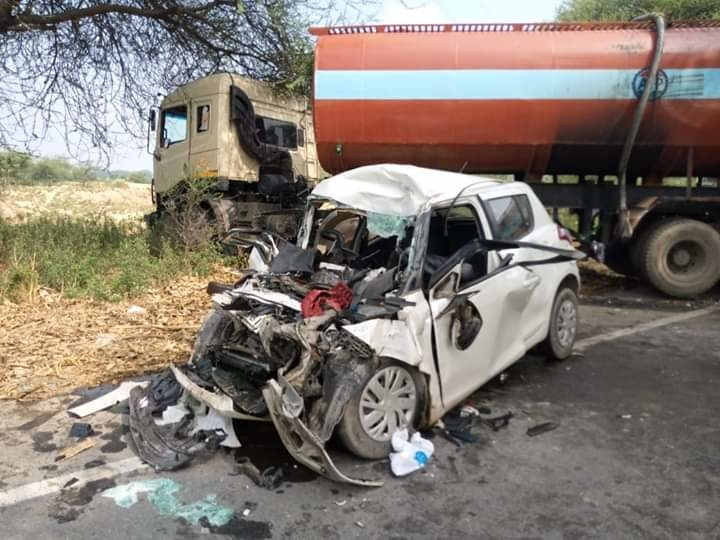

In [154]:
Image(image_url[0])

In [155]:
import requests
from bs4 import BeautifulSoup
import shutil
import base64
from PIL import Image as IMG
import praw
import os.path
from os import path
import random
from urllib.request import urlopen, Request
downloaded_data = []

def download_image(url,filename):
    try:
        print('==========================================================================')
        r = requests.get(url, stream=True)
        if r.status_code == 200:
            r.raw.decode_content = True
            with open(data_path+"test_data/"+filename, 'wb') as f:
                shutil.copyfileobj(r.raw, f)
            im1 = IMG.open(data_path+"test_data/"+filename)
            im1 = self.make_square(im1)
            downloaded_data.append(filename)
            im1.save(data_path+"test_data/"+filename)
        else:
            print('Image Couldn\'t be retreived')
            filename = 'not exist'
    except Exception :
        pass
    return filename

In [156]:
def test_data_creator(urls):
  test_images = []

  for url in urls:
    _file = url.split("/")[-1]
    filetype = _file.split('.')[-1]
    filename = (base64.b64encode(_file.encode("utf-8")).decode("utf-8"))[:-1] + '.jpg' 
    test_images.append(filename)

    img = download_image(url,filename)
  
  return test_images
test_images = test_data_creator(image_url)

In [157]:
test_images

['MjAyMF83JGxhcmdlaW1nXzk1NjAxNzg0Mi5qcGc.jpg']

In [158]:
df = pd.DataFrame(columns=["id"])
df['id'] = test_images
df['id'] = data_path+"test_data/"+df['id'].astype(str)
df.head()

,id
0,drive/MyDrive/Car Vision/test_data/MjAyMF83JGx...


In [159]:
test_dat = create_data_batches(df['id'],test_data=True)
predictions = model.predict(test_dat,verbose=1)

t_images_ = []

# loop through unbatch data
for image in test_dat.unbatch().as_numpy_iterator():
  t_images_.append(image)
  


Creating test data batches..............
1/1 [==============================] - 0s 32ms/step


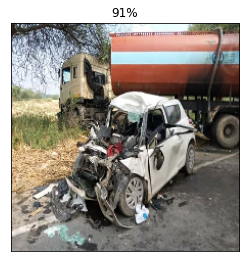

In [160]:
# t_images_
num_images = len(t_images_)
i_multiplier = 0
num_rows = 20
num_cols = 2
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  img = t_images_[i]
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

  plt.title(f"{predictions[i][0]*100:2.0f}%")
